## Bayesian Linear Regression 

This is the posterior Distribution for Bayesion Regresion

$$p(\vec{w} \mid \vec{t}) =  Norm(\vec{w} \mid \vec{m}_N, \vec{S}_N)$$ Parameters Updated Via

In [2]:
#self.posterior = mv_norm(mean=self.mN.flatten(), cov=self.SN)

$$\vec{S}^{-1}_N = \vec{S}_0^{-1} + \beta\vec{\Phi}^T\vec{\Phi} $$

In [3]:
# self.SN = np.linalg.inv(np.linalg.inv(self.S0) + self.beta*phi.T.dot(phi))

$$ \vec{m}_N = \vec{S}_N(\vec{S}_0^{-1}\vec{m}_0 + \beta\vec{\Phi}^T\vec{t}) $$ 

In [4]:
#self.mN = self.SN.dot(np.linalg.inv(self.S0).dot(self.m0) + self.beta*phi.T.dot(t))

In [60]:

import numpy as np
from numpy.random import normal, uniform
from scipy.stats import multivariate_normal as mv_norm
import matplotlib.pyplot as plt
%matplotlib inline

def real_function(a_0, a_1, noise_sigma, x):
    """
    Displays the real function
    """
    N = len(x)
    if noise_sigma==0:
        # Recovers the true function
        return a_0 + a_1*x
    else:
        return a_0 + a_1*x + normal(0, noise_sigma, N)
    
class LinearBayes(object):
    """
    Class for Bayesian Linear Regression 
    Holds prior and posterior parameters and handles hyper-parameter updates with new data
    Parameters:
        m0 (np.array): prior mean vector of size 1 x M
        S0 (np.ndarray): prior covaraince matrix of size MxM
        beta (float): a known real-data noise prediction
        
    """
    def __init__(self, m0, S0, beta):
        self.prior = mv_norm(mean=m0, cov=S0)
        self.m0 = m0.reshape(m0.shape + (1,)) #reshape to column vector
        self.S0 = S0
        self.beta = beta
        
        self.mN = self.m0
        self.SN = self.S0
        self.posterior = self.prior
    def get_phi(self, x):
        """
        Returns the design matrix of size (NxM) for a feature vector x.
        
        Parameters:
            x (np.array): input features of size 1xN
        """
        phi = np.ones((len(x), 2))
        phi[:, 1] = x
        return phi
    def fit(self, x, t):
        """
        Updates mN and SN given vectors of x-values and t-values
        """
        # Convert t from an array into a column vector
        # This is required to compute matrix multiplication
        t_vector = t.reshape(t.shape + (1,))
        phi = self.get_phi(x)
        
        #Calculate the Posterior Covariance Matrix
        self.SN = np.linalg.inv(np.linalg.inv(self.S0) + self.beta*phi.T.dot(phi))
        
        #Calculate the posterior mean vector
        self.mN = self.SN.dot(np.linalg.inv(self.S0).dot(self.m0) + self.beta*phi.T.dot(t_vector))
        
        #Set the posterior
        self.posterior = mv_norm(mean=self.mN.flatten(), cov=self.SN)
    def predict(self, x, stdevs):
        """
        Predicts the t for a given x with the given parameters mN and SN
        
        Parameter:
            x (np.array): input values of size 1xN
        
        Returns:
            np.array: the predicted t
        
        """
        N = len(x)
        m_x = self.get_phi(x).T.reshape((2, 1, N))
        
        predictions = []
        for idx in range(N):
            x = m_x[:,:,idx]
            sig_sq_x = 1/self.beta + x.T.dot(self.SN.dot(x))
            mean_x = self.mN.T.dot(x)
            predictions.append((mean_x+stdevs*np.sqrt(sig_sq_x)).flatten())
        return np.concatenate(predictions)
    def make_scatter(self, x, t, samples=None, stdevs=None):
        """
        Plot Scatter Plot of Real Data
        
        && Plot Fitted Lines to the Real Data as well as upper and lower limit given the number of standard deviations away 
        """
        plt.scatter(x, t)
        plt.xlabel('x')
        plt.ylabel('t')
        
        if samples:
            weights = self.posterior.rvs(samples)
            for weight in weights: 
                plt.plot([-1, 1], real_function(weight[0], weight[1], 0, np.array([-1., 1.])), 'black')
                _ = plt.title('Lines Sampled from Posterior Distribution vs Real Line and Data')
                
        if stdevs:
            xrange = np.linspace(-1, 1, 100)
            y_upper = self.predict(xrange, stdevs)
            y_lower = self.predict(xrange, -stdevs)
            plt.plot(xrange, y_upper, c='green', linewidth=4.0)
            plt.plot(xrange, y_lower, c='green', linewidth=4.0)
            _ = plt.title('Line Sampled from Posterior Distribution vs Real Data')

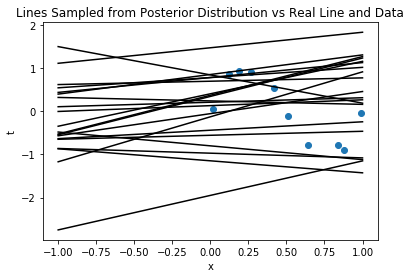

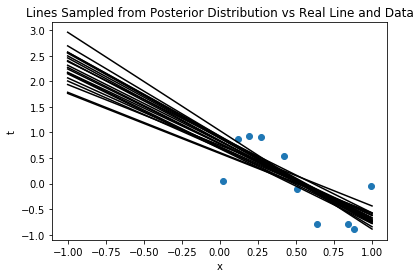

In [88]:
# Data
X = np.array([0.02, 0.12, 0.19, 0.27, 0.42, 0.51, 0.64, 0.84, 0.88, 0.99])
t = np.array([0.05, 0.87, 0.94, 0.92, 0.54, -0.11, -0.78, -0.79, -0.89, -0.04])

alpha = 2.0
m0 = np.array([0., 0.])
S0 = 1/alpha*np.identity(2)
noise_sigma = 0.2
beta = 1/noise_sigma**2

# Initialize Linear Bayes Regressor
regressor = LinearBayes(m0, S0, beta)
#Initial Plot Before Training
regressor.make_scatter(X, t, samples=20)
plt.show()
# Fit the Data
regressor.fit(X, t)
# Plot the Posterior Distribution vs the Real Data
regressor.make_scatter(X, t, samples=20)